In [1]:
from ishneholterlib import Holter
from pytz import timezone
import neurokit2 as nk
import yaml
import os
import zipfile
from datetime import datetime
from ecg_preproc import get_matching_files, extract_ecg_zip, get_holter_time_metadata

In [2]:
config = yaml.safe_load(open("config.yaml"))

In [3]:
import pandas as pd
f = "data/ema/sber_ema_20240429.csv"
df = pd.read_csv(f)
df['StartDate'] = pd.to_datetime(df['StartDate'])
df = df.sort_values(by='StartDate')
df = df[['pid', 'StartDate']].drop_duplicates(subset='pid', keep='first')
print(df.shape)
display(df)
df.to_csv("~/Downloads/sber_ema_pids.csv", index=False)

(237, 2)


/var/folders/st/_8t9rcwd49jf2y161kkqlch40000gn/T/ipykernel_83306/1974377016.py:3: DtypeWarning: Columns (132,168,169,176,177,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,235) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


,pid,StartDate
0,1030,2020-08-26 22:55:38+00:00
8,1036,2020-08-28 14:46:13+00:00
69,1092,2020-09-05 01:22:21+00:00
117,1415,2020-09-08 14:07:42+00:00
120,1035,2020-09-08 16:36:10+00:00
...,...,...
13461,11646,2022-02-25 14:43:51+00:00
13544,11419,2022-02-28 13:02:31+00:00
13639,11863,2022-03-03 03:12:23+00:00
13701,11467,2022-03-04 23:47:23+00:00


In [4]:
pid = "9552"
zip_dir = os.path.join("data/raw_zip", pid)
zip_filepath = get_matching_files(zip_dir, "*ECG_ISHNE.zip")[0]
ecg_dir = os.path.join("data/raw_ecg", pid)
# extract_ecg_zip(zip_filepath, extract_dir=ecg_dir)  


In [5]:
ecg_filepath = get_matching_files(ecg_dir, "*.ecg")[4]
ecg_holter = Holter(ecg_filepath)
ecg_holter.load_data()
start_ts = datetime(ecg_holter.record_date.year,
                    ecg_holter.record_date.month,
                    ecg_holter.record_date.day,
                    ecg_holter.start_time.hour,
                    ecg_holter.start_time.minute,
                    ecg_holter.start_time.second)

In [20]:
dir(ecg_holter)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'autofill_header',
 'beat_anns',
 'birth_date',
 'checksum',
 'compute_checksum',
 'copyright',
 'deidentify',
 'ecg_block_offset',
 'ecg_size',
 'file_date',
 'file_version',
 'filename',
 'first_name',
 'get_header_bytes',
 'get_length',
 'id',
 'is_annfile',
 'is_valid',
 'last_name',
 'lead',
 'load_ann',
 'load_data',
 'load_header',
 'magic_number',
 'nleads',
 'pm',
 'proprietary',
 'race',
 'record_date',
 'recorder_type',
 'reserved',
 'sex',
 'sr',
 'start_time',
 'var_block',
 'var_block_offset',
 'var_block_size',
 'write_file']

In [24]:
ecg_holter.get_length()

datetime.timedelta(seconds=3600)

In [3]:
get_holter_time_metadata("data/raw_ecg/9552")

[{'dir': 'data/raw_ecg/9552',
  'filename': 'ECGRec_202128_C866077_2022022407.ecg',
  'start_time': datetime.datetime(2022, 2, 24, 15, 0),
  'end_time': datetime.datetime(2022, 2, 24, 16, 0)},
 {'dir': 'data/raw_ecg/9552',
  'filename': 'ECGRec_202128_C866077_2022022413.ecg',
  'start_time': datetime.datetime(2022, 2, 24, 21, 0),
  'end_time': datetime.datetime(2022, 2, 24, 22, 0)},
 {'dir': 'data/raw_ecg/9552',
  'filename': 'ECGRec_202128_C866077_2022022605.ecg',
  'start_time': datetime.datetime(2022, 2, 26, 13, 0),
  'end_time': datetime.datetime(2022, 2, 26, 14, 0)},
 {'dir': 'data/raw_ecg/9552',
  'filename': 'ECGRec_202128_C866077_2022022611.ecg',
  'start_time': datetime.datetime(2022, 2, 26, 19, 0),
  'end_time': datetime.datetime(2022, 2, 26, 20, 0)},
 {'dir': 'data/raw_ecg/9552',
  'filename': 'ECGRec_202128_C866077_2022022822.ecg',
  'start_time': datetime.datetime(2022, 3, 1, 6, 0),
  'end_time': datetime.datetime(2022, 3, 1, 7, 0)},
 {'dir': 'data/raw_ecg/9552',
  'filena

In [11]:
ecg = ecg_holter.lead[0].data
ecg_clean = nk.ecg_clean(ecg, sampling_rate=128)
x = nk.ecg_delineate(ecg_clean, sampling_rate=128)
# returns 2-tuple with dataframe and dictionary with location of events

In [18]:
x[1].keys()

dict_keys(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets'])

In [21]:
import numpy as np
np.arange(0, 3600, 60)





array([   0,   60,  120,  180,  240,  300,  360,  420,  480,  540,  600,
        660,  720,  780,  840,  900,  960, 1020, 1080, 1140, 1200, 1260,
       1320, 1380, 1440, 1500, 1560, 1620, 1680, 1740, 1800, 1860, 1920,
       1980, 2040, 2100, 2160, 2220, 2280, 2340, 2400, 2460, 2520, 2580,
       2640, 2700, 2760, 2820, 2880, 2940, 3000, 3060, 3120, 3180, 3240,
       3300, 3360, 3420, 3480, 3540])

In [1]:
from ecg_preproc import ECGProcessor, get_holter_end_time, get_matching_files, get_holter_start_time
from ishneholterlib import Holter
import neurokit2 as nk

pid = "9552"
ecg_dir = "data/raw_ecg/" + pid
ecg_filepath = get_matching_files(ecg_dir, "*.ecg")[34]
ecg_holter = Holter(ecg_filepath)
ecg_holter.load_data()
start_time = get_holter_start_time(ecg_holter)
end_time = get_holter_end_time(ecg_holter)
print(f"start_time: {start_time}")
print(f"end_time: {end_time}")

ecg = ecg_holter.lead[0].data
print(f"ecg len: {len(ecg)}")
ecg_processor = ECGProcessor(pid=pid, ecg_signal=ecg, start_time=start_time, end_time=end_time)
# len(ecg_processor.ecg_raw)
# print(ecg_processor.ecg_raw)
# ecg_clean = ecg_processor.clean(ecg_processor.ecg_raw)
# df_rpeaks, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=128, method='rodrigues2021')
# print(ecg_processor.ecg_clean)
ecg_processor.run(".")


start_time: 2022-03-04 18:00:00
end_time: 2022-03-04 18:49:59
ecg len: 383872
[-0.054 -0.049 -0.055 ...  8.678  8.678  8.678]


# Plot average HR per time of day

This helps us determine if the timezone is properly aligned.

In [13]:
import pandas as pd
from ecg_preproc import get_matching_files, get_filename_start_ts
from datetime import datetime
import os
import neurokit2 as nk

pid = "9552"

# get all files from data/proc_ecg/{pid} that match "ECG_{pid}_meta_*.parquet"
meta_filepaths = get_matching_files(f"data/proc_ecg/{pid}", f"ECG_{pid}_meta_*.parquet")
rpeaks_filepaths = get_matching_files(f"data/proc_ecg/{pid}", f"ECG_{pid}_rpeaks_*.parquet")

dfs = []
for i, rpeaks_filepath in enumerate(rpeaks_filepaths):
    df = pd.read_parquet(rpeaks_filepath)
    start_time = get_filename_start_ts(rpeaks_filepath)
    df['timestamp'] = start_time + pd.to_timedelta(df.index / 128, unit='s')
    df['filepath'] = rpeaks_filepath
    df['file_num'] = i
    dfs.append(df)
    # break
    # if i % 10 == 0:
    #     print(f"processed {i+1} files")
    
df_rpeaks = pd.concat(dfs, ignore_index=True)

# Convert from UTC to Los Angeles time (Pacific Time)
df_rpeaks['timestamp'] = df_rpeaks['timestamp'].dt.tz_localize('UTC').dt.tz_convert('America/Los_Angeles')


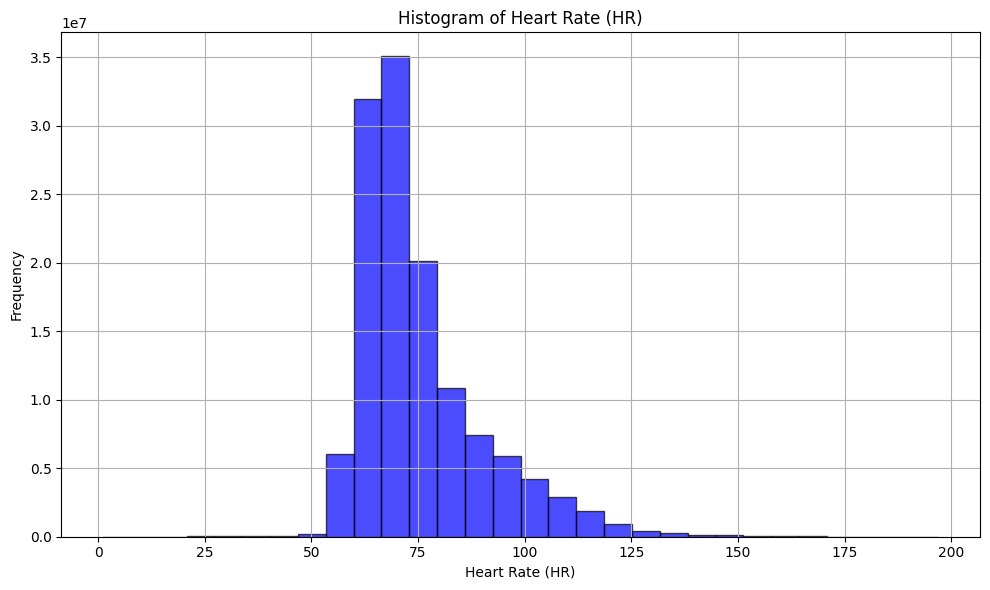

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram of the HR column
plt.figure(figsize=(10, 6))
plt.hist(df_rpeaks['HR'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Heart Rate (HR)')
plt.ylabel('Frequency')
plt.title('Histogram of Heart Rate (HR)')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

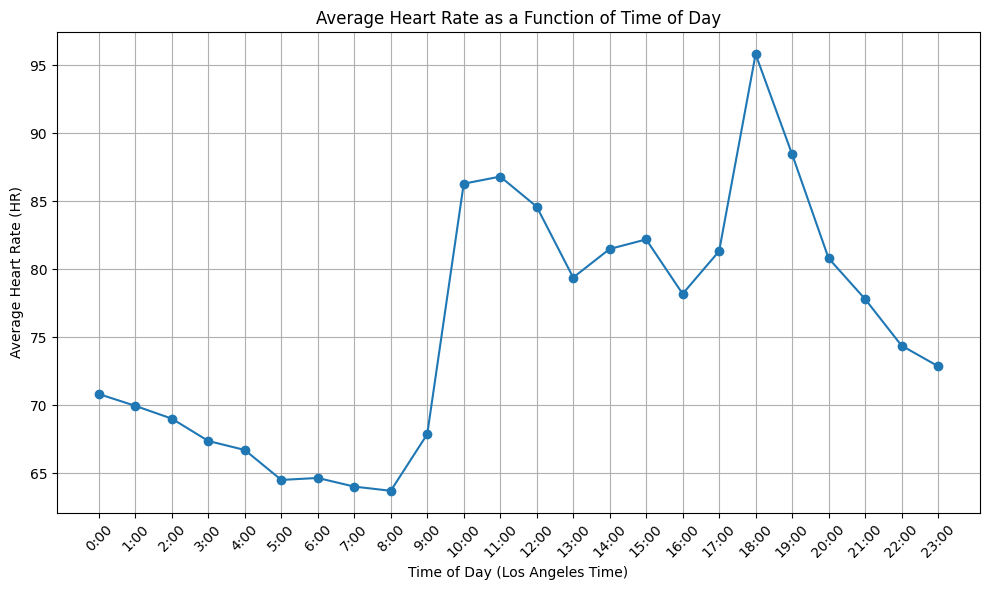

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz


# Cap HR at 200
df_rpeaks['HR'] = np.clip(df_rpeaks['HR'], a_min=None, a_max=200)

# Extract the hour of the day in Los Angeles time
df_rpeaks['hour_of_day'] = df_rpeaks['timestamp'].dt.hour

# Group by hour of the day and calculate the mean HR for each hour
hourly_avg_hr = df_rpeaks.groupby('hour_of_day')['HR'].mean()

# Plot the averaged HR vs time of day (hours)
plt.figure(figsize=(10, 6))
plt.plot(hourly_avg_hr.index, hourly_avg_hr.values, marker='o')

# Set the x-ticks to represent hours and slightly rotate the labels
plt.xticks(ticks=range(24), labels=[f'{i}:00' for i in range(24)], rotation=45)

plt.xlabel('Time of Day (Los Angeles Time)')
plt.ylabel('Average Heart Rate (HR)')
plt.title('Average Heart Rate as a Function of Time of Day')
plt.grid(True)
plt.tight_layout()
plt.show()

# PDFs of ECG and R-peaks

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import yaml
import numpy as np
from ecg_preproc import get_matching_files, get_filename_start_ts

config = yaml.safe_load(open("config.yaml"))

pid = "9552"

# Load the files
meta_filepaths = get_matching_files(f"data/proc_ecg/{pid}", f"ECG_{pid}_meta_*.parquet")
rpeaks_filepaths = get_matching_files(f"data/proc_ecg/{pid}", f"ECG_{pid}_rpeaks_*.parquet")
signal_filepaths = get_matching_files(f"data/proc_ecg/{pid}", f"ECG_{pid}_signal_*.parquet")
qrs_filepaths = get_matching_files(f"data/proc_ecg/{pid}", f"ECG_{pid}_qrs_*.parquet")

start_ts = datetime(2022, 2, 26, 19, 0, 0)
meta_filepath = [f for f in meta_filepaths if get_filename_start_ts(f) == start_ts][0]
rpeak_filepath = [f for f in rpeaks_filepaths if get_filename_start_ts(f) == start_ts][0]
signal_filepath = [f for f in signal_filepaths if get_filename_start_ts(f) == start_ts][0]
qrs_filepath = [f for f in qrs_filepaths if get_filename_start_ts(f) == start_ts][0]

df_rpeaks = pd.read_parquet(rpeak_filepath)
df_signal = pd.read_parquet(signal_filepath)
df_qrs = pd.read_parquet(qrs_filepath)
df_meta = pd.read_parquet(meta_filepath)


def plot_ecg_with_rpeaks(df_signal, df_rpeaks, df_meta, output_pdf, sample_rate=128):
    

    epochs = df_meta['epoch'].unique()
    
    window_size = sample_rate * config['epoch_seconds'] 

    with PdfPages(output_pdf) as pdf_pages:
        for epoch in epochs:

            epoch_start = df_meta.loc[df_meta['epoch'] == epoch].index[0]
            epoch_end = df_meta.loc[df_meta['epoch'] == epoch].index[-1] + 1
            quality = df_meta.loc[epoch_start, 'quality']

            plt.figure(figsize=(10, 6))
            
            # Plot ECG signal
            time_axis = np.arange(epoch_start, epoch_end) / sample_rate  # Convert samples to seconds
            plt.plot(time_axis, df_signal['ecg'][epoch_start:epoch_end], label='ECG signal')

            # Mark R-peaks
            r_peaks_in_window = df_rpeaks['ECG_R_Peaks'][epoch_start:epoch_end].astype(bool)
            r_peak_times = np.where(r_peaks_in_window)[0] / sample_rate + epoch_start / sample_rate  # Align R-peak times
            
            plt.scatter(
                r_peak_times,
                df_signal['ecg'][epoch_start:epoch_end][r_peaks_in_window],
                color='red',
                label='R Peaks'
            )

            plt.title(f'ECG Signal with R Peaks from {epoch_start/sample_rate/60:.2f} to {epoch_end/sample_rate/60:.2f} minutes (Quality: {quality})')
            plt.xlabel('Time (seconds)')
            plt.ylabel('ECG')
            plt.legend()

            # Save the plot to the PDF
            pdf_pages.savefig()
            plt.close()

            
# Call the plotting function
plot_ecg_with_rpeaks(df_signal, df_rpeaks, df_meta, 'ecg_signal_rpeaks_with_quality.pdf')

In [17]:
qrs_filepath = [f for f in qrs_filepaths if get_filename_start_ts(f) == start_ts][0]
df_qrs = pd.read_parquet(qrs_filepath)
print(df_qrs.columns)
df_qrs.head()

Index(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets'],
      dtype='object')


,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [23]:
phase_filepaths = get_matching_files(f"data/proc_ecg/{pid}", f"ECG_{pid}_phase_*.parquet")
phase_filepath = [f for f in phase_filepaths if get_filename_start_ts(f) == start_ts][0]
df_phase = pd.read_parquet(phase_filepath)
print(df_phase.columns)
df_phase.value_counts()
display(df_phase.tail())

Index(['ECG_Phase_Atrial', 'ECG_Phase_Completion_Atrial',
       'ECG_Phase_Ventricular', 'ECG_Phase_Completion_Ventricular'],
      dtype='object')


,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
460795,NaN,0.0,NaN,0.0
460796,NaN,0.0,NaN,0.0
460797,NaN,0.0,NaN,0.0
460798,NaN,0.0,NaN,0.0
460799,NaN,0.0,NaN,0.0


In [63]:
df_meta

,timestamp,quality,epoch
0,2022-02-26 19:00:00.000000000,1,0
1,2022-02-26 19:00:00.007812500,1,0
2,2022-02-26 19:00:00.015625000,1,0
3,2022-02-26 19:00:00.023437500,1,0
4,2022-02-26 19:00:00.031250000,1,0
...,...,...,...
460795,2022-02-26 19:59:59.960937500,2,119
460796,2022-02-26 19:59:59.968750000,2,119
460797,2022-02-26 19:59:59.976562500,2,119
460798,2022-02-26 19:59:59.984375000,2,119
